# Intergalactic propagation of UHECRs

This notebook exemplifies how to simulate the propagation of UHECRs over cosmological distances.
It considers that the sources are uniformly distributed and have a power-law spectrum with spectral index $\alpha$ an exponential cut-off at some rigidity $R_\text{max}$.
The simulation is done assuming this spectrum to be $E^{-1}$, but at the post-processing stage any desired spectral index can be obtained.

(This simulations may take a couple of minutes.)

### Assembling a simulation

In [1]:
from crpropa import *

# general options
nEvents = 30000
energyRange = (1 * EeV, 1000 * EeV)
distanceRange = (0., 1000. * Mpc)
A, Z = 14, 7
cmb = CMB()
ebl = IRB_Gilmore12()
outputFile = 'sim/03-sim1D-A_%02i_Z_%02i.txt' % (A, Z)

# source distribution: uniform with power-law spectrum
position = SourceUniform1D(*distanceRange)
direction = SourceDirection(Vector3d(-1, 0, 0)) # emit in the -x direction (1D simulation)
redshift = SourceRedshift1D() # takes the positions and assign the corresponding redshifts
energySpectrum = SourcePowerLawSpectrum(*energyRange, -1)
particleType = SourceParticleType(nucleusId(A, Z))
source = Source()
source.add(position)
source.add(redshift) 
source.add(direction)
source.add(energySpectrum)
source.add(particleType)

# output
outputType = Output.Event1D
output = TextOutput(outputFile, outputType)
output.disable(output.CandidateTagColumn)
output.setEnergyScale(eV)
output.setLengthScale(Mpc)

# observer 
observerType = Observer1D()
observer = Observer()
observer.add(observerType)
observer.onDetection(output)

# interactions
pdCMB = PhotoDisintegration(cmb)
pdEBL = PhotoDisintegration(ebl)
pppCMB = PhotoPionProduction(cmb)
pppEBL = PhotoPionProduction(ebl)
eppCMB = ElectronPairProduction(cmb)
eppEBL = ElectronPairProduction(ebl)
nd = NuclearDecay()
z = Redshift()
processes = [pdCMB, pdEBL, pppCMB, pppEBL, eppCMB, eppEBL, nd, z]

# propagator: one-dimensional
propagator = SimplePropagation(0.1 * kpc, 1 * Mpc)

# break conditions
breakTrajectory = MaximumTrajectoryLength(1000 * Mpc)
breakEnergy = MinimumEnergy(1 * EeV)

# assemble simulation components
sim = ModuleList()
sim.add(propagator)
for interaction in processes:
	sim.add(interaction)
sim.add(observer)
sim.add(breakEnergy)
sim.add(breakTrajectory)
sim.setShowProgress(True)
sim.run(source, nEvents, True)

output.close()


crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Mon Aug 21 19:23:36 2023 : [ Finished ] 100%    Needed: 00:01:00  - Finished at Mon Aug 21 19:24:36 2023


Now we proceed with the postprocessing of the simulation.
Note that we wish to simulate a spectrum $E^{-\alpha}$ with an exponential cut-off at rigidities $R_\mathrm{max}$.
Since we simulated a $E_0^{-1}$ spectrum, we must reweight the simulation to obtain the desired injection spectrum.

### Helper functions

Functions for reading the simulations and obtaining the spectrum are provided below, including this reweighting procedure.

In [2]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output.
	"""
	# infer header names
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]
	
	# read file
	df = pd.read_csv(filename, delimiter = '\t', comment = '#', names = names)

	return df

def reweightSimulation(df, alpha, Rmax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Rmax`: spectrum cuts off above Z Rmax, where Z is the atomic number of the nucleus \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0, z0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (z0 * Rmax))
	w = np.array([computeWeight(df['E0'][i], chargeNumber(int(df['ID0'][i]))) for i in range(len(df['E0']))])
	df[columnName] = w / np.sum(w)

def computeSpectrum(df, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	bins = np.logspace(18, 21, 16, endpoint = True)
	y, edges = np.histogram(df['E'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	y /= np.amax(y)

	return x, y

### Read simulations

Now we read the simulation and study three scenarios with different combinations of spectral index and maximal rigidity.

In [3]:
data = readSimulation(outputFile)
reweightSimulation(data, 2.0, 1e19, columnName = 'W1')
reweightSimulation(data, 1.5, 3e19, columnName = 'W2')
reweightSimulation(data, 1.2, 7e18, columnName = 'W3')
x1, y1 = computeSpectrum(data, columnName = 'W1')
x2, y2 = computeSpectrum(data, columnName = 'W2')
x3, y3 = computeSpectrum(data, columnName = 'W3')

### Plotting

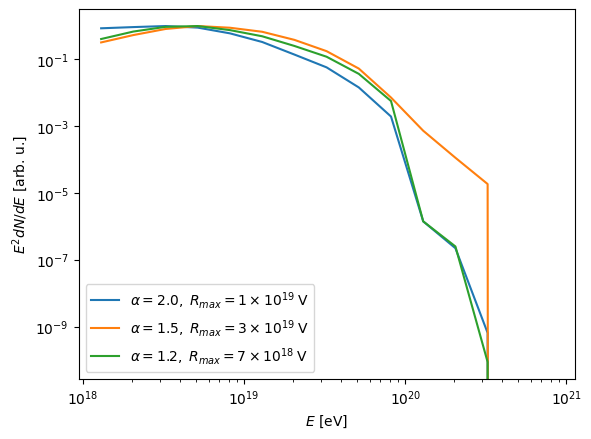

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x1, y1, label = '$\\alpha = 2.0, \\; R_{max} = 1 \\times 10^{19} \\; \\mathrm{V}$')
plt.plot(x2, y2, label = '$\\alpha = 1.5, \\; R_{max} = 3 \\times 10^{19} \\; \\mathrm{V}$')
plt.plot(x3, y3, label = '$\\alpha = 1.2, \\; R_{max} = 7 \\times 10^{18} \\; \\mathrm{V}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$E^2 dN/dE$ [arb. u.]')
plt.xlabel('$E$ [eV]')
plt.legend(loc = 'lower left')
plt.show()
